In [1]:
import pandas as pd

import numpy as np
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import tree
from sklearn.metrics import recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split

In [3]:
def simple_clearing_train(df_train: pd.DataFrame, fill_percent_threshold=97,
        corr_percent_threshold=100, onlyfloat=False):
    df = df_train
    # Дроп столбцов, заполненных меньше, чем не fiil_percent_threshold %
    df = df.drop(columns=[col for col in df.columns
        if df[col].count() / len(df.index) < fill_percent_threshold / 100])
    # Замена None в категориальных данных на новый категориальный признак
    categorical_columns = [col for col in df.columns if str(df[col].dtype) == 'object']
    df[categorical_columns] = df[categorical_columns].fillna('CatNone')
    # Замена NaN в числовых данных на медианное значение
    float_columns = [col for col in df.columns if str(df[col].dtype) == 'float64']
    df[float_columns] = df[float_columns].fillna(df[float_columns].median())
    # Разбиение категории segment на пять бинарных столбцов
    dummies = pd.get_dummies(df,
        columns=['segment'])[[f'segment_{n}' for n in [0, 1, 2, 3, 'CatNone']]].astype(np.float64)
    segment_idx = df.columns.get_loc('segment')
    df = df.drop(columns=['segment'])
    for n in ['CatNone', 3, 2, 1, 0]:
        df.insert(segment_idx, f'segment_{n}', dummies[f'segment_{n}'])
    # Если интересуют только числовые данные
    if onlyfloat:
        float_columns = [col for col in df.columns if str(df[col].dtype) in ('float64', 'int32')]
        df = df[float_columns]
    # Дроп столбцов, кореллирующих с какими-либо другими более, чем на corr_percent_threshold %
    if corr_percent_threshold < 100:
        float_columns = [col for col in df.columns if str(df[col].dtype) == 'float64']
        dff = df[float_columns]
        dff_corr = dff.corr()
        most_corellated_pairs = [
            (dff.columns[i], dff.columns[j], dff_corr[dff.columns[i]].loc[dff.columns[j]])
            for i in range(len(dff.columns))
            for j in range(i+1, len(dff.columns))
        ]
        most_corellated_pairs.sort(
            key=lambda col_pair: abs(col_pair[2]), reverse=True
        )
        most_corellated_pairs = pd.DataFrame(data=most_corellated_pairs,
            columns=['feature_1', 'feature_2', 'correllation'])
        mcp = most_corellated_pairs
        while mcp['correllation'].iloc[0] > (corr_percent_threshold / 100):
            c11 = (mcp['feature_1'].value_counts().loc[mcp['feature_1'].iloc[0]]
                if mcp['feature_1'].iloc[0] in mcp['feature_1'].value_counts().index else 0)
            c21 = (mcp['feature_2'].value_counts().loc[mcp['feature_1'].iloc[0]]
                if mcp['feature_1'].iloc[0] in mcp['feature_2'].value_counts().index else 0)
            c12 = (mcp['feature_1'].value_counts().loc[mcp['feature_2'].iloc[0]]
                if mcp['feature_2'].iloc[0] in mcp['feature_1'].value_counts().index else 0)
            c22 = (mcp['feature_2'].value_counts().loc[mcp['feature_2'].iloc[0]]
                if mcp['feature_2'].iloc[0] in mcp['feature_2'].value_counts().index else 0)
            excessive_feature = mcp['feature_1'].iloc[0] if c11 + c21 < c12 + c22 else mcp['feature_2'].iloc[0]
            df = df.drop(columns=[excessive_feature])
            dff = dff.drop(columns=[excessive_feature])
            dff_corr = dff_corr.drop(columns=[excessive_feature])
            dff_corr = dff_corr.drop(index=[excessive_feature])
            mcp = mcp.loc[(mcp['feature_1'] != excessive_feature) & (mcp['feature_2'] != excessive_feature)]
    return df

def simple_clearing_test(df_test: pd.DataFrame, df_train_clean: pd.DataFrame):
    # Выбор только тех столбцов, которые были в трейне
    targets = ['target_1', 'target_2', 'total_target']

    # Разбиение категории segment на пять бинарных столбцов
    dummies = pd.get_dummies(df_test, columns=['segment'])
    if 'segment_CatNone' not in dummies.columns:
        dummies.insert(len(dummies.columns), 'segment_CatNone', 0.0)
    dummies = dummies[[f'segment_{n}' for n in [0, 1, 2, 3, 'CatNone']]].astype(np.float64)
    segment_idx = df_test.columns.get_loc('segment')
    df_test = df_test.drop(columns=['segment'])
    for n in ['CatNone', 3, 2, 1, 0]:
        df_test.insert(segment_idx, f'segment_{n}', dummies[f'segment_{n}'])
    
    df_train_clean_columns = [col for col in df_train_clean.columns if col not in targets]
    df_test = df_test[df_train_clean_columns]
    # Замена None в категориальных данных на новый категориальный признак
    categorical_columns = [col for col in df_test.columns if str(df_test[col].dtype) == 'object']
    df_test[categorical_columns] = df_test[categorical_columns].fillna('CatNone')
    # Замена NaN в числовых данных на медианное значение
    float_columns = [col for col in df_test.columns if str(df_test[col].dtype) == 'float64']
    df_test[float_columns] = df_test[float_columns].fillna(df_test[float_columns].median())
    return df_test

In [4]:
file_path = 'C:/Users/user/Documents/Hahaton/test.parquet'
test_data = pd.read_parquet(file_path, engine='pyarrow')

file_path = 'C:/Users/user/Documents/Hahaton/train.parquet'
train_data = pd.read_parquet(file_path, engine='pyarrow')

train_data = simple_clearing_train(train_data, 97, 100, False)

categorical_columns = [col for col in train_data.columns if str(train_data[col].dtype) == 'object']

train_data = train_data.drop(columns=categorical_columns)

train_data.isnull().any().sum()

0

In [5]:
test_data = simple_clearing_test(test_data, train_data)

In [6]:
def clear_outliers_column(df1, column, a_max, b_min):
    a_max = df1[column].max()*a_max
    b_min = df1[column].min()*b_min
    df1 = df1.drop(df1[df1[column] < b_min].index)
    df1 = df1.drop(df1[df1[column] > a_max].index)
    
    print(df1.shape[0])
    
    # print(column, a_max, b_min)
    return df1


def clear_outliers_all(df1):
    try:
        # rko_start_months
        df1 = clear_outliers_column(df1, 'rko_start_months', 0.6, 0.9)
        print(df1.size())
    except:
        print('rko_start_months')
            
    try:
        # balance_amt_avg
        df1 = clear_outliers_column(df1, 'balance_amt_avg', 0.2, 1)
        print(df1.size())
    except:
        print('balance_amt_avg')
            
    try:
        # balance_amt_max
        df1 = clear_outliers_column(df1, 'balance_amt_max', 0.05, 1)
        print(df1.size())
    except:
        print('balance_amt_max')
            
    try:
        # balance_amt_min
        df1 = clear_outliers_column(df1, 'balance_amt_min', 0.25, 1)
        print(df1.size())
    except:
        print('balance_amt_min')
            
    try:
        # balance_amt_day_avg
        df1 = clear_outliers_column(df1, 'balance_amt_day_avg', 0.5, 1)
        print(df1.size())
    except:
        print('balance_amt_day_avg')
            
    try:
        # ogrn_days_end_month
        df1 = clear_outliers_column(df1, 'ogrn_days_end_month', 0.9, 0.9)
        print(df1.size())
    except:
        print('ogrn_days_end_month')
            
    try:
        # ogrn_days_end_quarter
        df1 = clear_outliers_column(df1, 'ogrn_days_end_quarter', 0.9, 0.9)
        print(df1.size())
    except:
        print('ogrn_days_end_quarter')
            
    try:
        # ogrn_exist_months
        df1 = clear_outliers_column(df1, 'ogrn_exist_months', 0.9, 0.9)
        print(df1.size())
    except:
        print('ogrn_exist_months')
            
    try:
        # sum_of_paym_2m
        df1 = clear_outliers_column(df1, 'sum_of_paym_2m', 0.2, 1)
        print(df1.size())
    except:
        print('sum_of_paym_2m')
            
    try:
        # sum_of_paym_6m
        df1 = clear_outliers_column(df1, 'sum_of_paym_6m', 0.15, 1)
        print(df1.size())
    except:
        print('sum_of_paym_6m')
            
    try:
        # sum_of_paym_1y
        df1 = clear_outliers_column(df1, 'sum_of_paym_1y', 0.3, 1)
        print(df1.size())
    except:
        print('sum_of_paym_1y')
            
    try:
        # sum_a_oper_1m
        df1 = clear_outliers_column(df1, 'sum_a_oper_1m', 0.25, 1)
        print(df1.size())
    except:
        print('sum_a_oper_1m')
            
    try:
        # cnt_a_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_a_oper_1m', 0.5, 1)
        print(df1.size())
    except:
        print('cnt_a_oper_1m')
            
    try:
        # sum_b_oper_1m
        df1 = clear_outliers_column(df1, 'sum_b_oper_1m', 0.25, 1)
        print(df1.size())
    except:
        print('sum_b_oper_1m')
            
    try:
        # cnt_b_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_b_oper_1m', 0.1, 1)
        print(df1.size())
    except:
        print('cnt_b_oper_1m')
            
    try:
        # sum_c_oper_1m
        df1 = clear_outliers_column(df1, 'sum_c_oper_1m', 0.25, 1)
        print(df1.size())
    except:
        print('sum_c_oper_1m')
            
    try:
        # cnt_c_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_c_oper_1m', 0.25, 1)
        print(df1.size())
    except:
        print('cnt_c_oper_1m')
            
    try:
        # sum_deb_d_oper_1m
        df1 = clear_outliers_column(df1, 'sum_deb_d_oper_1m', 0.2, 0.9)
        print(df1.size())
    except:
        print('sum_deb_d_oper_1m')
            
    try:
        # cnt_deb_d_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_deb_d_oper_1m', 0.2, 0.9)
        print(df1.size())
    except:
        print('cnt_deb_d_oper_1m')
            
    try:
        # sum_cred_d_oper_1m
        df1 = clear_outliers_column(df1, 'sum_cred_d_oper_1m', 0.2, 0.9)
        print(df1.size())
    except:
        print('sum_cred_d_oper_1m')
            
    try:
        # cnt_cred_d_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_cred_d_oper_1m', 0.2, 1)
        print(df1.size())
    except:
        print('cnt_cred_d_oper_1m')
            
    try:
        # sum_deb_e_oper_1m
        df1 = clear_outliers_column(df1, 'sum_deb_e_oper_1m', 0.2, 1)
        print(df1.size())
    except:
        print('sum_deb_e_oper_1m')
            
    try:
        # cnt_deb_e_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_deb_e_oper_1m', 0.4, 1)
        print(df1.size())
    except:
        print('cnt_deb_e_oper_1m')
            
    try:
        # sum_cred_e_oper_1m
        df1 = clear_outliers_column(df1, 'sum_cred_e_oper_1m', 0.3, 1)
        print(df1.size())
    except:
        print('sum_cred_e_oper_1m')
            
    try:
        # cnt_cred_e_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_cred_e_oper_1m', 0.1, 1)
        print(df1.size())
    except:
        print('cnt_cred_e_oper_1m')
            
    try:
        # cnt_days_cred_e_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_days_cred_e_oper_1m', 0.95, 0.9)
        print(df1.size())
    except:
        print('cnt_days_cred_e_oper_1m')
            
    try:
        # sum_deb_f_oper_1m
        df1 = clear_outliers_column(df1, 'sum_deb_f_oper_1m', 0.2, 1)
        print(df1.size())
    except:
        print('sum_deb_f_oper_1m')
            
    try:
        # cnt_deb_f_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_deb_f_oper_1m', 0.2, 1)
        print(df1.size())
    except:
        print('cnt_deb_f_oper_1m')
            
    try:
        # sum_cred_f_oper_1m
        df1 = clear_outliers_column(df1, 'sum_cred_f_oper_1m', 0.3, 1)
        print(df1.size())
    except:
        print('sum_cred_f_oper_1m')
            
    try:
        # cnt_cred_f_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_cred_f_oper_1m', 0.5, 1)
        print(df1.size())
    except:
        print('cnt_cred_f_oper_1m')
            
    try:
        # cnt_days_cred_f_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_days_cred_f_oper_1m', 0.8, 1)
        print(df1.size())
    except:
        print('cnt_days_cred_f_oper_1m')
          
    try:
        # sum_deb_g_oper_1m
        df1 = clear_outliers_column(df1, 'sum_deb_g_oper_1m', 0.3, 1)
        print(df1.size())
    except:
        print('sum_deb_g_oper_1m')
            
    try:
        # cnt_deb_g_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_deb_g_oper_1m', 0.4, 1)
        print(df1.size())
    except:
        print('cnt_deb_g_oper_1m')
    
    try:
        # sum_cred_g_oper_1m
        df1 = clear_outliers_column(df1, 'sum_cred_g_oper_1m', 0.4, 0.8)
        print(df1.size())
    except:
        print('sum_cred_g_oper_1m')  
    
    try:
        # cnt_cred_g_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_cred_g_oper_1m', 0.4, 1)
        print(df1.size())
    except:
        print('cnt_cred_g_oper_1m') 
    
    try:
        # cnt_days_cred_g_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_days_cred_g_oper_1m', 0.7, 0.7)
        print(df1.size())
    except:
        print('cnt_days_cred_g_oper_1m')
         
    try:
        # cnt_deb_h_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_deb_h_oper_1m', 0.3, 1)
        print(df1.size())
    except:
        print('cnt_deb_h_oper_1m')
         
    try:
        # sum_cred_h_oper_1m
        df1 = clear_outliers_column(df1, 'sum_cred_h_oper_1m', 0.3, 1)
        print(df1.size())
    except:
        print('sum_cred_h_oper_1m')
    
    try:
        # cnt_cred_h_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_cred_h_oper_1m', 0.3, 1)
        print(df1.size())
    except:
        print('cnt_cred_h_oper_1m')
            
    try:
        # sum_a_oper_3m
        df1 = clear_outliers_column(df1, 'sum_a_oper_3m', 0.8, 1)
        print(df1.size())
    except:
        print('sum_a_oper_3m')
            
    try:
        # cnt_a_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_a_oper_3m', 0.3, 0.7)
        print(df1.size())
    except:
        print('cnt_a_oper_3m')
            
    try:
        # sum_b_oper_3m
        df1 = clear_outliers_column(df1, 'sum_b_oper_3m', 0.3, 1)
        print(df1.size())
    except:
        print('sum_b_oper_3m')
            
    try:
        # cnt_b_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_b_oper_3m', 0.8, 1)
        print(df1.size())
    except:
        print('cnt_b_oper_3m')
        
    try:
        # sum_c_oper_3m
        df1 = clear_outliers_column(df1, 'sum_c_oper_3m', 0.3, 0.7)
        print(df1.size())
    except:
        print('sum_c_oper_3m')
    
    try:
        # cnt_c_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_c_oper_3m', 0.3, 0.7)
        print(df1.size())
    except:
        print('cnt_c_oper_3m')
    
    try:
        # sum_deb_d_oper_3m
        df1 = clear_outliers_column(df1, 'sum_deb_d_oper_3m', 0.3, 1)
        print(df1.size())
    except:
        print('sum_deb_d_oper_3m')
        
    try:
        # cnt_deb_d_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_deb_d_oper_3m', 0.3, 1)
        print(df1.size())
    except:
        print('cnt_deb_d_oper_3m')
    
    try:
        # sum_cred_d_oper_3m
        df1 = clear_outliers_column(df1, 'sum_cred_d_oper_3m', 0.2, 0.5)
        print(df1.size())
    except:
        print('sum_cred_d_oper_3m')
            
    try:
        # cnt_cred_d_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_cred_d_oper_3m', 0.3, 1)
        print(df1.size())
    except:
        print('cnt_cred_d_oper_3m')  
    
    try:
        # sum_deb_e_oper_3m
        df1 = clear_outliers_column(df1, 'sum_deb_e_oper_3m', 0.2, 1)
        print(df1.size())
    except:
        print('sum_deb_e_oper_3m')
         
    try:
        # cnt_deb_e_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_deb_e_oper_3m', 0.6, 1)
        print(df1.size())
    except:
        print('cnt_deb_e_oper_3m')
         
    
    try:
        # cnt_days_deb_e_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_deb_e_oper_3m', 1, 1)
        print(df1.size())
    except:
        print('cnt_days_deb_e_oper_3m')
         
    try:
        # sum_cred_e_oper_3m
        df1 = clear_outliers_column(df1, 'sum_cred_e_oper_3m', 0.3, 1)
        print(df1.size())
    except:
        print('sum_cred_e_oper_3m')
    
    try:
        # cnt_cred_e_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_cred_e_oper_3m', 0.3, 0.7)
        print(df1.size())
    except:
        print('cnt_cred_e_oper_3m')
    
    try:
        # cnt_days_cred_e_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_days_cred_e_oper_3m', 0.9, 0.9)
        print(df1.size())
    except:
        print('cnt_days_cred_e_oper_3m')
         
    
    try:
        # sum_deb_f_oper_3m
        df1 = clear_outliers_column(df1, 'sum_deb_f_oper_3m', 0.3, 0.8)
        print(df1.size())
    except:
        print('sum_deb_f_oper_3m')
         
    try:
        # cnt_deb_f_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_deb_f_oper_3m', 0.3, 1)
        print(df1.size())
    except:
        print('cnt_deb_f_oper_3m') 
    
    try:
        # sum_cred_f_oper_3m
        df1 = clear_outliers_column(df1, 'sum_cred_f_oper_3m', 0.3, 0.7)
        print(df1.size())
    except:
        print('sum_cred_f_oper_3m')
    
    try:
        # cnt_cred_f_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_cred_f_oper_3m', 0.6, 0.8)
        print(df1.size())
    except:
        print('cnt_cred_f_oper_3m')
    
    try:
        # cnt_days_cred_f_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_days_cred_f_oper_3m', 0.8, 1)
        print(df1.size())
    except:
        print('cnt_days_cred_f_oper_3m')
    
    try:
        # sum_deb_g_oper_3m
        df1 = clear_outliers_column(df1, 'sum_deb_g_oper_3m', 0.3, 1)
        print(df1.size())
    except:
        print('sum_deb_g_oper_3m')
        
    try:
        # cnt_deb_g_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_deb_g_oper_3m', 0.3, 0.8)
        print(df1.size())
    except:
        print('cnt_deb_g_oper_3m')
        
    try:
        # sum_cred_g_oper_3m
        df1 = clear_outliers_column(df1, 'sum_cred_g_oper_3m', 0.3, 0.8)
        print(df1.size())
    except:
        print('sum_cred_g_oper_3m')
    
    try:
        # cnt_cred_g_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_cred_g_oper_3m', 0.3, 1)
        print(df1.size())
    except:
        print('cnt_cred_g_oper_3m')
        
    try:
        # sum_deb_h_oper_3m
        df1 = clear_outliers_column(df1, 'sum_deb_h_oper_3m', 0.3, 0.8)
        print(df1.size())
    except:
        print('sum_deb_h_oper_3m')
        
    try:
        # cnt_deb_h_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_deb_h_oper_3m', 0.3, 1)
        print(df1.size())
    except:
        print('cnt_deb_h_oper_3m')
        
    try:
        # cnt_days_deb_h_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_days_deb_h_oper_3m', 0.8, 0.8)
        print(df1.size())
    except:
        print('cnt_days_deb_h_oper_3m')
        
    try:
        # sum_cred_h_oper_3m
        df1 = clear_outliers_column(df1, 'sum_cred_h_oper_3m', 0.3, 0.8)
        print(df1.size())
    except:
        print('sum_cred_h_oper_3m')
        
    try:
        # cnt_cred_h_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_cred_h_oper_3m', 0.3, 0.8)
        print(df1.size())
    except:
        print('cnt_cred_h_oper_3m')
        
    try:
        # cnt_days_cred_h_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_days_cred_h_oper_3m', 0.9, 1)
        print(df1.size())
    except:
        print('cnt_days_cred_h_oper_3m')
        
    
    return df1


In [7]:
train_data = clear_outliers_all(train_data)

299732
rko_start_months
299716
balance_amt_avg
299358
balance_amt_max
298919
balance_amt_min
298890
balance_amt_day_avg
298877
ogrn_days_end_month
298853
ogrn_days_end_quarter
298823
ogrn_exist_months
sum_of_paym_2m
sum_of_paym_6m
sum_of_paym_1y
298354
sum_a_oper_1m
298351
cnt_a_oper_1m
298323
sum_b_oper_1m
296847
cnt_b_oper_1m
296830
sum_c_oper_1m
296803
cnt_c_oper_1m
296792
sum_deb_d_oper_1m
296768
cnt_deb_d_oper_1m
296746
sum_cred_d_oper_1m
296740
cnt_cred_d_oper_1m
296433
sum_deb_e_oper_1m
296423
cnt_deb_e_oper_1m
295943
sum_cred_e_oper_1m
295752
cnt_cred_e_oper_1m
295746
cnt_days_cred_e_oper_1m
295707
sum_deb_f_oper_1m
295698
cnt_deb_f_oper_1m
295666
sum_cred_f_oper_1m
295662
cnt_cred_f_oper_1m
295611
cnt_days_cred_f_oper_1m
295400
sum_deb_g_oper_1m
295386
cnt_deb_g_oper_1m
295290
sum_cred_g_oper_1m
295248
cnt_cred_g_oper_1m
294546
cnt_days_cred_g_oper_1m
294456
cnt_deb_h_oper_1m
292748
sum_cred_h_oper_1m
292699
cnt_cred_h_oper_1m
292688
sum_a_oper_3m
292458
cnt_a_oper_3m
292454
s

In [8]:
train_data




,id,rko_start_months,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,ogrn_days_end_month,ogrn_days_end_quarter,ft_registration_date,ogrn_exist_months,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,target_1,target_2,total_target
0,0,-1.279132,0.495465,-0.150694,-0.061040,0.244948,1.753402,0.550625,-0.901816,-0.879679,...,0.352516,-0.081310,0.210189,1.140808,0.647477,0.810887,1.909568,0,0,0
1,1,-1.142591,0.441660,-0.151974,0.444538,-0.336615,-1.071369,0.843839,-0.102824,-0.499765,...,-0.188287,-0.650616,-0.316563,-1.136536,-0.127326,-0.147319,-0.517805,0,0,0
2,2,1.812270,0.721481,0.690313,0.712110,0.687942,1.447976,2.002672,0.423129,0.264662,...,-0.323487,0.632731,2.541558,3.017482,0.033394,0.019972,0.578428,0,0,0
3,3,-0.479407,-0.825400,-0.164479,-0.081552,-0.345380,1.332294,-0.963345,1.529426,1.538181,...,-0.323487,-0.003549,-0.219016,0.228624,-0.428185,-0.220932,-0.596108,0,0,0
4,4,-1.503690,-0.220356,-0.140007,0.054151,-0.012974,-0.642853,0.022619,-1.042687,-1.307176,...,-0.323487,0.182726,-0.287299,-0.528921,-0.563335,-0.021506,-0.361201,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,0.140494,0.318171,0.382156,0.137893,-0.316382,0.773977,1.795861,-0.622795,-0.923123,...,0.082114,0.276906,0.346755,1.535162,0.718633,-0.242059,-0.047991,0,0,0
299996,299996,-0.578334,-0.257132,-0.163073,-0.306348,-0.214342,0.198610,-0.024177,0.466641,0.412151,...,-0.323487,-0.264553,-0.316563,-0.472916,-0.053175,0.222753,-0.596108,0,0,0
299997,299997,2.052711,0.275272,-0.023917,0.577519,0.125595,-0.704130,0.800814,0.197954,0.646429,...,-0.323487,0.139359,-0.316563,-0.768966,-0.115407,-0.054465,-0.047991,0,0,0
299998,299998,1.051685,0.407648,-0.173676,-0.059733,-0.090080,-2.261586,-1.722783,2.460043,2.728104,...,-0.188287,-0.122459,-0.316563,-0.317586,0.829699,-0.416806,-0.596108,0,1,1


In [9]:
train_data.drop(["id", "target_1","target_2"], axis=1, inplace=True)


In [10]:
y = train_data.total_target
x = train_data.drop("total_target", axis=1)

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x, y,
                                                  random_state=42)

In [15]:
#model = RandomForestClassifier(n_estimators=100, max_depth = 10, random_state = 0) #0.86 при 10 глубине БЕЗ Димы 0,864 при 20 глубине 0.8628 и 0,8624 с Димой при 10 глубине
model = LGBMClassifier(verbosity=-1, random_state = 42,  n_estimators=100, max_depth = 8, num_leaves = 70, learning_rate = 0.05, bootstrap = False, extra_trees = False, xgboost_dart_mode = True, feature_fraction = 0.9, reg_alpha = 0.9, reg_lambda = 0.9) #0.87569
#model = CatBoostClassifier(verbose=0, n_estimators=100, random_state = 42, learning_rate = 0.05, max_depth = 8) -нет, ибо мало
#model = svm.SVC() # оооочень долго, не дождались
#model = tree.DecisionTreeClassifier(max_depth = 7, random_state = 0) # 0.84935 - for 7 // 0.8485 С Димой
model.fit(x_train, y_train)

LGBMClassifier(bootstrap=False, extra_trees=False, feature_fraction=0.9,
               learning_rate=0.05, max_depth=8, num_leaves=70, random_state=42,
               reg_alpha=0.9, reg_lambda=0.9, verbosity=-1,
               xgboost_dart_mode=True)

In [16]:
y_pred = model.predict_proba(x_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8740925162049461

In [17]:
test_score = model.predict_proba(test_data.drop("id", axis=1))[:, 1]
sample_submission_df = pd.read_csv("C:/Users/user/Documents/Hahaton/sample_submission.csv")
sample_submission_df.head()
sample_submission_df["score"] = test_score
sample_submission_df.head()
sample_submission_df.to_csv("C:/Users/user/Documents/Hahaton/result.csv", index=False)

In [18]:
#train_data.info()

In [19]:
#test_data.info()

In [20]:
df = pd.read_csv("C:/Users/user/Documents/Hahaton/result.csv")
df

,id,score
0,300000,0.429721
1,300001,0.495005
2,300002,0.007708
3,300003,0.007070
4,300004,0.016561
...,...,...
99995,399995,0.019011
99996,399996,0.017648
99997,399997,0.034655
99998,399998,0.025503


In [21]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[256772   1903]
 [ 16749   4147]]


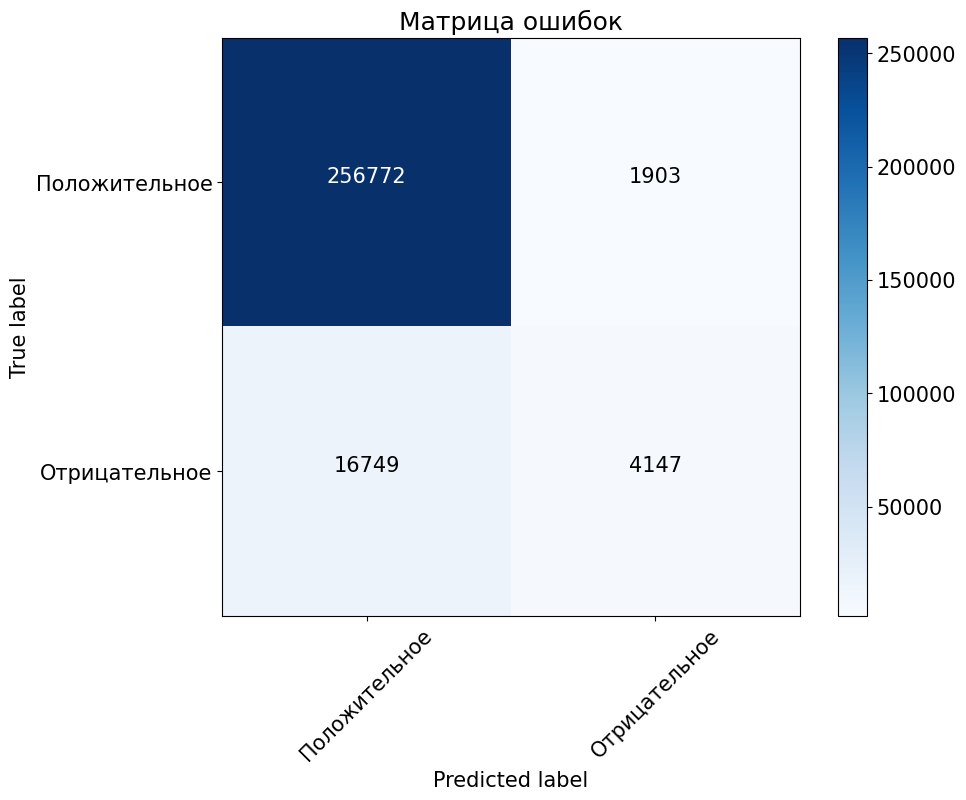

In [22]:
import itertools

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y, model.predict(x))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Положительное', 'Отрицательное'],
                      title='Матрица ошибок')
plt.show()

In [23]:
report = classification_report(y, model.predict(x), target_names=['Положительное', 'Отрицательное'])
print(report)

               precision    recall  f1-score   support

Положительное       0.94      0.99      0.96    258675
Отрицательное       0.69      0.20      0.31     20896

     accuracy                           0.93    279571
    macro avg       0.81      0.60      0.64    279571
 weighted avg       0.92      0.93      0.92    279571



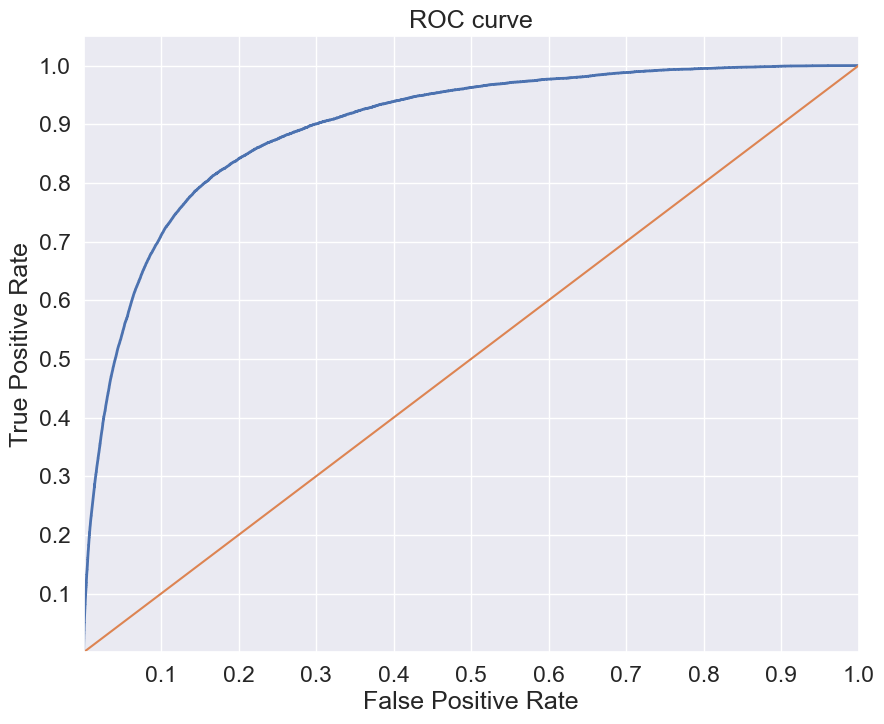

In [38]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y, model.predict_proba(x)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.xticks([i/10 for i in range(1,11)])
plt.ylim([0.0, 1.05])
plt.yticks([i/10 for i in range(1,11)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [42]:
y_prob = model.predict_proba(x)[:, 1]
roc_auc_score(y, y_prob)


0.8975404387545436